<a href="https://colab.research.google.com/github/im-hjk/dankook_dacon/blob/master/08_stacking_lgb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# lgb stacking

## 라이브러리 import 및 설정

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from google.colab import drive 
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import lightgbm as lgb
from matplotlib import pyplot as plt
from matplotlib import rcParams
import numpy as np
from pathlib import Path
import io
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold
import seaborn as sns
import warnings

In [4]:
rcParams['figure.figsize'] = (16, 8)
plt.style.use('fivethirtyeight')
pd.set_option('max_columns', 100)
pd.set_option("display.precision", 4)
warnings.simplefilter('ignore')

## 학습데이터 로드

[03-pandas-eda.ipynb](https://github.com/kaggler-tv/dku-kaggle-class/blob/master/notebook/03-pandas-eda.ipynb)에서 생성한 `feature.csv` 피처파일 사용

In [5]:
main_path = Path('/content/drive/My Drive/Colab Notebooks/dacon_dkdkdk')
data_dir = main_path / 'data/dacon-dku'
feature_dir = main_path / 'build/feature'
val_dir = main_path / 'build/val'
tst_dir = main_path / 'build/tst'
sub_dir = main_path / 'build/sub'

trn_file = data_dir / 'train.csv'
tst_file = data_dir / 'test.csv'
sample_file = data_dir / 'sample_submission.csv'

target_col = 'class'
n_fold = 5
n_class = 3
seed = 42

In [6]:
algo_name = 'lgbcv'
feature_name = 'stacking1'
model_name = f'{algo_name}_{feature_name}'

feature_file = feature_dir / f'{feature_name}.csv'
p_val_file = val_dir / f'{model_name}.val.csv'
p_tst_file = tst_dir / f'{model_name}.tst.csv'
sub_file = sub_dir / f'{model_name}.csv'

## Stacking Feature 생성

In [7]:
model_names = ['lrcv_polyfeature', 'rfcv_feature', 'lgbcv_feature']
trn = []
tst = []
feature_names = []
for model in model_names:
    trn.append(np.loadtxt(val_dir / f'{model}.val.csv', delimiter=','))
    tst.append(np.loadtxt(tst_dir / f'{model}.tst.csv', delimiter=','))
    feature_names += [f'{model}_class0', f'{model}_class1', f'{model}_class2']
    
trn = np.hstack(trn)
tst = np.hstack(tst)
feature_names

['lrcv_polyfeature_class0',
 'lrcv_polyfeature_class1',
 'lrcv_polyfeature_class2',
 'rfcv_feature_class0',
 'rfcv_feature_class1',
 'rfcv_feature_class2',
 'lgbcv_feature_class0',
 'lgbcv_feature_class1',
 'lgbcv_feature_class2']

In [8]:
y = pd.read_csv(trn_file, index_col=0, usecols=['id', target_col]).values.flatten()
y.shape

(320000,)

## Stratified K-Fold Cross Validation

In [9]:
cv = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=seed)

## LightGBM 모델 학습

In [10]:
p_val = np.zeros((trn.shape[0], n_class))
p_tst = np.zeros((tst.shape[0], n_class))
for i, (i_trn, i_val) in enumerate(cv.split(trn, y), 1):
    print(f'training model for CV #{i}')
    clf = lgb.LGBMClassifier(objective='multiclass',
                             n_estimators=1000,
                             num_leaves=64,
                             learning_rate=0.1,
                             min_child_samples=10,
                             subsample=.5,
                             subsample_freq=1,
                             colsample_bytree=.8,
                             random_state=seed,
                             n_jobs=-1)
    clf.fit(trn[i_trn], y[i_trn],
            eval_set=[(trn[i_val], y[i_val])],
            eval_metric='multiclass',
            early_stopping_rounds=10)
    
    p_val[i_val, :] = clf.predict_proba(trn[i_val])
    p_tst += clf.predict_proba(tst) / n_fold

training model for CV #1
[1]	valid_0's multi_logloss: 0.871144
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's multi_logloss: 0.778958
[3]	valid_0's multi_logloss: 0.703082
[4]	valid_0's multi_logloss: 0.63852
[5]	valid_0's multi_logloss: 0.58355
[6]	valid_0's multi_logloss: 0.536285
[7]	valid_0's multi_logloss: 0.495184
[8]	valid_0's multi_logloss: 0.459098
[9]	valid_0's multi_logloss: 0.427516
[10]	valid_0's multi_logloss: 0.399611
[11]	valid_0's multi_logloss: 0.375274
[12]	valid_0's multi_logloss: 0.353691
[13]	valid_0's multi_logloss: 0.334407
[14]	valid_0's multi_logloss: 0.317242
[15]	valid_0's multi_logloss: 0.301961
[16]	valid_0's multi_logloss: 0.288315
[17]	valid_0's multi_logloss: 0.276098
[18]	valid_0's multi_logloss: 0.265161
[19]	valid_0's multi_logloss: 0.255508
[20]	valid_0's multi_logloss: 0.246658
[21]	valid_0's multi_logloss: 0.238807
[22]	valid_0's multi_logloss: 0.231887
[23]	valid_0's multi_logloss: 0.225734
[24]	valid_0's multi_loglos

In [11]:
print(f'{accuracy_score(y, np.argmax(p_val, axis=1)) * 100:.4f}%')

93.1713%


In [12]:
print(p_val.shape, p_tst.shape)

(320000, 3) (80000, 3)


In [13]:
np.savetxt(p_val_file, p_val, fmt='%.6f', delimiter=',')
np.savetxt(p_tst_file, p_tst, fmt='%.6f', delimiter=',')

## 피처 중요도 시각화

In [14]:
#clf.coef_.shape

AttributeError: ignored

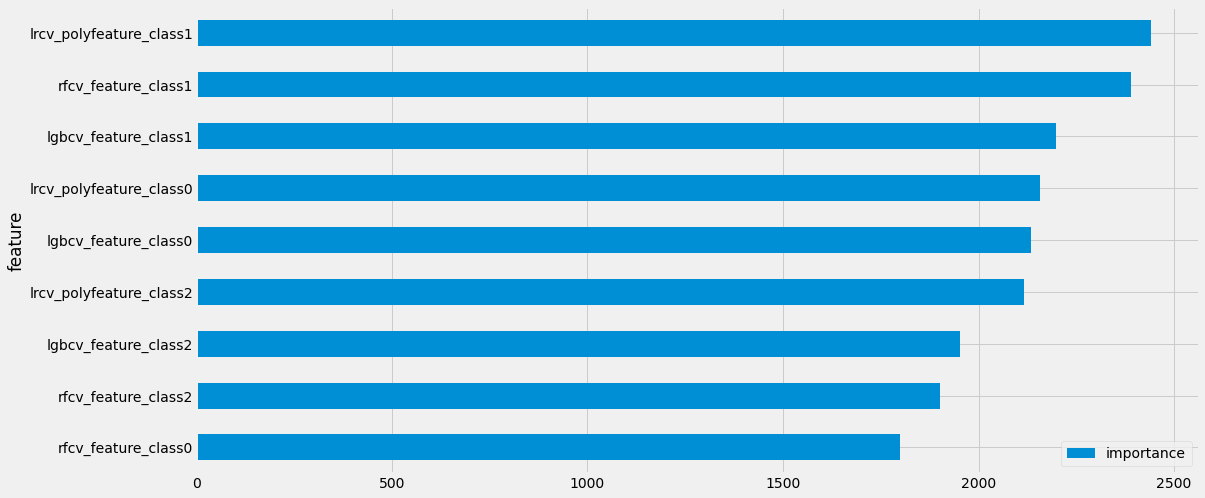

In [15]:
imp = pd.DataFrame({'feature': feature_names, 'importance': clf.feature_importances_})
imp = imp.sort_values('importance').set_index('feature')
imp.plot(kind='barh')

## 제출 파일 생성

In [16]:
sub = pd.read_csv(sample_file, index_col=0)
print(sub.shape)
sub.head()

(80000, 1)


,class
id,
320000,0
320001,0
320002,0
320003,0
320004,0


In [17]:
sub[target_col] = np.argmax(p_tst, axis=1)
sub.head()

,class
id,
320000,2
320001,0
320002,2
320003,0
320004,2


In [18]:
sub[target_col].value_counts()

2    40611
0    29987
1     9402
Name: class, dtype: int64

In [19]:
sub.to_csv(sub_file)